# Mixture Density Networks

A _mixture density network_ (MDN) is an interesting model formalism built within the general framework of neural networks and probability theory for working on supervised learning problems in which the target variable cannot be easily approximated by a single standard probability distribution.  Essentially, an MDN allows one to model a conditional probability distribution $p(\mathbf{y}|\mathbf{x})$ as a mixture of distributions, in which the individual distributions and the corresponding mixture coefficients are parameterized by functions of the inputs $\mathbf{x}$.

In this blog post, we'll explore this scenario, take a quick deep dive into the math, starting with intuitions and ending with a model and a probabilistically-derived loss function, and build an MDN for an example dataset.  As a great resource, we'll be pulling heavily from Bishop's [Pattern Recognition and Machine Learning (PRML)](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book).

Let's get started!

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = (8, 8)
np.random.seed(42)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Generate data
To begin with, let's generate a training dataset that matches that from PRML, p. 272.  Specifically, let's generate a matrix $\mathbf{X}$ of $n$ observations of a 1-dimensional variable $\mathbf{x}$ by sampling uniformly over the interval $[0, 1)$, and then generate a corresponding matrix $\mathbf{Y}$ of $n$ target observations of a 1-dimensional variable $\mathbf{y}$ by computing

$$\mathbf{Y} = \mathbf{X} + 0.3\sin(2\pi \mathbf{X}) + \mathbf{noise}\text{,}$$

where $\mathbf{noise}$ is a vector of $n$ uniform values sampled over the interval $[-0.1, 0.1)$.

We'll also generate a matrix $\mathbf{X}^{\text{test}}$ of $n$ scalar values spaced evenly over the interval $[0, 1)$ to use for sampling predictions.  Note that this post is focused on exploring the ability to approximate different conditional distributions $p(\mathbf{y}|\mathbf{x})$, rather than on the full learning problem of generalization, so we don't make use of the usual train/val/test split, or attempt to generate val/test values outside of the $[0, 1)$ interval to test for generalization.  However, a full application involving MDNs would certainly make use of these standard practices.

In [3]:
# generate data
n = 2500
d = 1
t = 1
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
y_train = x_train + 0.3*np.sin(2*np.pi*x_train) + noise
x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)

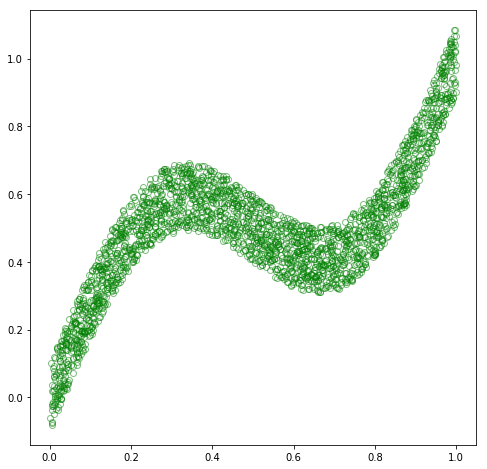

In [4]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
plt.show()

## Train a model
Now, let's train a model to learn the process that generated this dataset, i.e., the mapping from $\mathbf{x}$ to $\mathbf{y}$, or the conditional distribution $p(\mathbf{y}|\mathbf{x})$.  For this dataset, $p(\mathbf{y}|\mathbf{x})$ is unimodal, i.e., there appears to be a single distribution over $\mathbf{y}$ for each observation of $\mathbf{x}$.  Thus, we could assume a Gaussian distribution for $p(\mathbf{y}|\mathbf{x})$, and treat this problem as a standard regression problem.  Therefore, we need to construct a model that accepts an example $\mathbf{x}_i$ and produces a value $\mathbf{out}_i$, which we can interpret as the mean parameter of a Gaussian distribution for $\mathbf{y}_i$.  We can then construct a loss function as the negative log likelihood assuming a Gaussian distribution, and optimize this loss w.r.t. the parameters of our model.  In terms of the actual model, we can make use of a neural network as a general framework for function approximation, and construct a simple, two-layer, non-linear neural net with a sufficient number of parameters to be able to fit the given dataset.

In terms of computing frameworks, here we will make use of [PyTorch](https://github.com/pytorch/pytorch), which is a fantastic framework for working with deep neural networks.  As a quick overview, at the core, PyTorch has a GPU-accelerated tensor library with `Tensor` objects that provide functionality akin to NumPy.  This could be used to build and optimize a neural net by implementing forward and backward (gradient) functions directly, and then proceeding with optimization.  As a convenience, PyTorch has an automatic differentiation package built on top of the tensor library that provides the ability to automatically construct the correct graph of gradient functions for a given sequence of forward functions.  This is exposed in a lightweight manner by wrapping a `Tensor` object in a `Variable` wrapper, which exposes the same functionality as the core `Tensor`, but with the added benefit of constructing a graph of backward functions corresponding to the lineage of functions that generated that `Variable` object.  Finally, PyTorch has a lightweight neural network package, `nn`, built on top of the tensor and autograd packages that wraps common groups of computation and associated parameters, which we commonly think of as "layers", into higher-level `Module` abstractions as a convenience.

Alright, let's create a simple neural network (using mostly raw autograd), and train it on our dataset.

In [5]:
# define a simple neural net
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
  out = torch.tanh(x.mm(w1) + b1)  # a relu introduces kinks in the predicted curve
  out = out.mm(w2) + b2
  return out

# wrap up the data as Variables
x = Variable(torch.from_numpy(x_train))
y = Variable(torch.from_numpy(y_train))

# select an optimizer
# NOTE: there are a few options here -- feel free to explore!
# opt = optim.SGD([w1, b1, w2, b2], lr=0.1)
opt = optim.SGD([w1, b1, w2, b2], lr=0.09, momentum=0.9, nesterov=True)
# opt = optim.RMSprop([w1, b1, w2, b2], lr=0.002, alpha=0.999)
# opt = optim.Adam([w1, b1, w2, b2], lr=0.09)

# optimize
# 10000 for SGD, 2000 for SGD w/ nesterov momentum, 4000 for RMSprop, 800 for Adam
for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data[0])
  loss.backward()
  opt.step()

0 0.1318715214729309
100 0.02118375524878502
200 0.020730936899781227
300 0.01997489295899868
400 0.018774135038256645
500 0.016968224197626114
600 0.014197885058820248
700 0.010265103541314602
800 0.006506440695375204
900 0.0048077101819217205
1000 0.004334129858762026
1100 0.004653463140130043
1200 0.004246124066412449
1300 0.004021362401545048
1400 0.0038556407671421766
1500 0.0037298458628356457
1600 0.0036344509571790695
1700 0.0035621628630906343
1800 0.003507356159389019
1900 0.0034657230135053396


Great! Now, let's make predictions and plot the values against the original dataset to see how well we are able to approximate the training dataset.

In [6]:
# predict
out = forward(Variable(torch.from_numpy(x_test)))

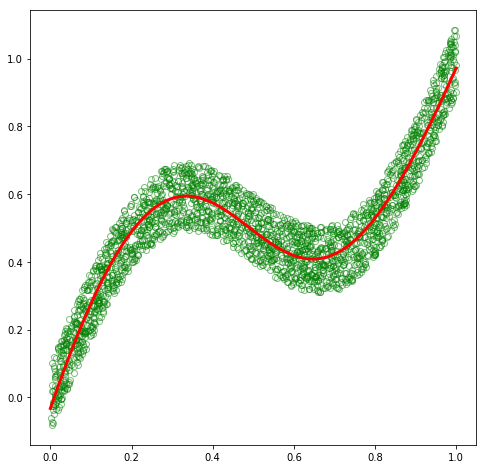

In [7]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth=3.0)
plt.show()

As expected, our basic model was able to fit this dataset.  So why do we need MDNs?!

## Inverse problem

To motivate the usefulness of MDNs, let's invert the problem by swapping $\mathbf{X}$ and $\mathbf{Y}$ as

$$\mathbf{X} = \mathbf{Y} + 0.3\sin(2\pi \mathbf{Y}) + \mathbf{noise}\text{,}$$

and then solve for $\mathbf{Y}$.

In [8]:
x_train_inv = y_train
y_train_inv = x_train
x_test = np.linspace(-0.1, 1.1, n).reshape(-1, 1).astype(np.float32)  # new x has a slightly different range

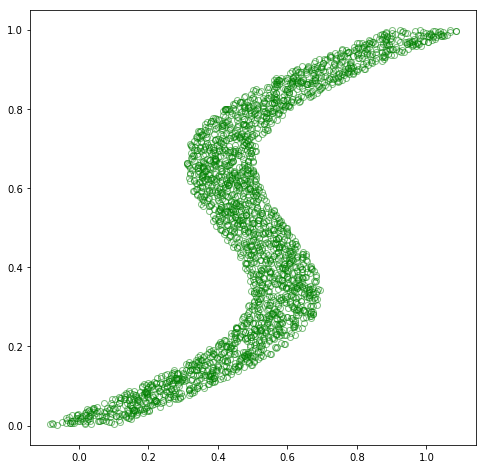

In [9]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.show()

Alright, no problem, right?!  Let's make use of the same model structure, fit this new dataset, and then get out of here. 

In [10]:
# define a simple neural net
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
  out = torch.tanh(x.mm(w1) + b1)  # a relu introduces kinks in the predicted curve
  out = out.mm(w2) + b2
  return out

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

# select an optimizer
# opt = optim.SGD([w1, b1, w2, b2], lr=0.1)
# opt = optim.SGD([w1, b1, w2, b2], lr=0.09, momentum=0.9, nesterov=True)
# opt = optim.RMSprop([w1, b1, w2, b2], lr=0.002, alpha=0.999)
opt = optim.Adam([w1, b1, w2, b2], lr=0.09)

# optimize
for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data[0])
  loss.backward()
  opt.step()

0 0.3315950334072113
100 0.04737946018576622
200 0.0473075695335865
300 0.04726357012987137
400 0.04718540236353874
500 0.04666971415281296
600 0.04502996802330017
700 0.0439254529774189
800 0.04220931604504585
900 0.040625568479299545
1000 0.040246326476335526
1100 0.042346663773059845
1200 0.039997708052396774
1300 0.03994014114141464
1400 0.03996961563825607
1500 0.03990992531180382
1600 0.0424722321331501
1700 0.039900049567222595
1800 0.039857689291238785
1900 0.04052538797259331


In [11]:
# predict
out = forward(Variable(torch.from_numpy(x_test)))

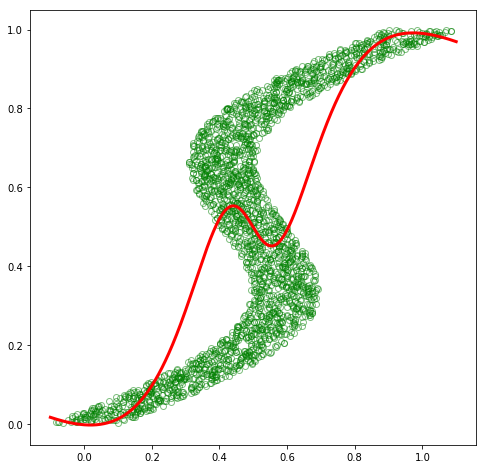

In [12]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth=3.0)
plt.show()

Ouch! Unfortunately, our model was not able to fit this inverse dataset at all.  If we think about it a bit, we can see that this is a hard problem for a regular model with a single output to effectively fit.  In the original dataset, although there was some amount of noise, there appeared to be a single, distinct distribution of $\mathbf{y}$ for each observation of $\mathbf{x}$, and thus a Gaussian distribution parameterized by a function of $\mathbf{x}$ was able to approximate $p(\mathbf{y}|\mathbf{x})$ quite well.  However, in this inverse dataset, there appear to be multiple distinct distributions of $\mathbf{y}$ for many of the $\mathbf{x}$ observations, and thus a single Gaussian distribution is not able to approximate this multimodal conditional distribution.

What if our model could parameterize a _mixture_ of Gaussian distributions to approximate $p(\mathbf{y}|\mathbf{x})$?  Bingo – this is exactly the goal of a MDN.  Let's try it!

## Mixture density networks

As mentioned at the beginning of our exploration, an MDN is a flexible framework for modeling an arbitrary conditional probability distribution $p(\mathbf{y}|\mathbf{x})$ as a mixture of distributions, parameterized by functions of the input $\mathbf{x}$.  More specifically, we can construct an MDN by creating a neural network to parameterize a mixture model consisting of some predefined types of distributions.  For this dataset, we'll continue to make use of Gaussian distributions, and thus our neural net will parameterize a Gaussian mixture model (GMM), which is effectively a normalized linear combination of $K$ Gaussian distributions.  Formally, we can express the conditional probability $p(\mathbf{y}|\mathbf{x})$ as

$$
p(\mathbf{y}|\mathbf{x}) = \sum_k \pi_k(\mathbf{x}) N(\mathbf{y}|\boldsymbol{\mu}_k(\mathbf{x}), I\sigma_k^2(\mathbf{x})) \text{,}
$$

where $\boldsymbol{\pi}(\mathbf{x})$ is a normalized vector of $k$ _mixing coefficients_ as a function of $\mathbf{x}$, and $N(\mathbf{y}|\boldsymbol{\mu}_k(\mathbf{x}), I\sigma_k^2(\mathbf{x}))$ is a Gaussian _component density_ with means $\boldsymbol{\mu}_k(\mathbf{x})$ and variance $\sigma_k^2(\mathbf{x})$, both of which are also functions of $\mathbf{x}$.  Note that although we use per-dimensional means, we simplify the covariance matrix to be isotropic, i.e., equal variances for each dimension of $\mathbf{x}$ (see PRML, p. 273).  Also note that the mixing coefficients, means, and variances are all functions of the inputs $\mathbf{x}$, and as such, represent the outputs of our neural net. 

Let's unpack this a bit.  Essentially, we decided that our original approach of approximating $p(\mathbf{y}|\mathbf{x})$ with a _single_ Gaussian distribution was insufficient, and that making use of multiple Gaussians could be more effective.  Thus, we constructed a framework in which, for a given observation of $\mathbf{x}$, our model outputs the parameters for $K$ Gaussian distributions, as well as $K$ coefficients summing to one that indicate the relative amounts by which to combine the distributions.  Then, for some new observation of $\mathbf{x}$, we could generate the parameters of this mixture model to form a complex distribution of $\mathbf{y}$, from which we could draw samples in various ways to generate probable predictions of $\mathbf{y}$.

The formalism we've employed thus far is intuitive, but it is also a bit ad-hoc.  If we are interested, we can take the math a bit further to clean it up and fit it nicely into a general probabilistic framework.  Let's start with the mixing coefficients $\pi_k(\mathbf{x})$.  We know that these coefficients are constrained to sum to one, and we noted that intuitively they represent the relative amounts by which to mix the associated Gaussian components.  Thus, we can interpret these coefficients as probabilities of the $K$ Gaussian components for a given observation of $\mathbf{x}$.  The vector $\boldsymbol{\pi}(\mathbf{x})$ then represents a probability distribution, and we could condition the Gaussian component portion of our formulation upon this distribution.  In order to formally do this, we could introduce a _latent variable_ $\mathbf{z}$ that is one-hot encoded with $K$ possible states, and then $\boldsymbol{\pi}(\mathbf{x})$ could represent the distribution $p(\mathbf{z})$.  More specifically, we can define $p(z_k = 1) = \pi_k(\mathbf{x})$, i.e., define $\pi_k(\mathbf{x})$ as the probability of $\mathbf{z}$ being in state $k$, and thus as the prior probability of the $k^{\text{th}}$ mixture component.  Given this, we could then formalize our idea of a conditional Gaussian component as $p(\mathbf{y}|\mathbf{x},\mathbf{z})$, in which we condition the distribution of $\mathbf{y}$ on both $\mathbf{x}$ and our new variable $\mathbf{z}$.  Given our new $p(\mathbf{z})$ and $p(\mathbf{y}|\mathbf{x},\mathbf{z})$ distributions, we can construct a joint distribution $p(\mathbf{y}, \mathbf{z}|\mathbf{x})$ between $\mathbf{y}$ and $\mathbf{z}$, and then construct our conditional distribution $p(\mathbf{y}|\mathbf{x})$ by marginalizing this joint distribution over the latent variable $\mathbf{z}$:

$$
\begin{align}
p(\mathbf{y}|\mathbf{x}) & = \int p(\mathbf{y},\mathbf{z}|\mathbf{x})d\mathbf{z} \\
 & = \sum_{\mathbf{z}} p(\mathbf{y},\mathbf{z}|\mathbf{x}) \\
 & = \sum_{\mathbf{z}} p(\mathbf{z})p(\mathbf{y}|\mathbf{x},\mathbf{z}) \\
 & = \sum_k \pi_k(\mathbf{x}) N(\mathbf{y}|\mathbf{\mu}_k(\mathbf{x}), I\sigma_k^2(\mathbf{x})) \text{.}
\end{align}
$$

The benefit here is that our intuitive notions are now formulated in a clean, probabilistic manner.

All that remains here is to explicitly introduce our model parameters, and derive an appropriate loss function that we can optimize.  Up until now, we have discussed our model outputs as functions of $\mathbf{x}$, without explicitly mentioning any parameters of the model.  Let's now explicitly introduce $\mathbf{w}$ as our vector of trainable model parameters, and restate our model as a function of both $\mathbf{x}$ and $\mathbf{w}$, or better yet as a function of $\mathbf{x}$ parameterized by $\mathbf{w}$.  The conditional distribution $p(\mathbf{y}|\mathbf{x})$ can then be updated to explicitly include $\mathbf{w}$:

$$
\begin{align}
p(\mathbf{y}|\mathbf{x},\mathbf{w}) & = \int p(\mathbf{y},\mathbf{z}|\mathbf{x},\mathbf{w})d\mathbf{z} \\
 & = \sum_k \pi_k(\mathbf{x},\mathbf{w}) N(\mathbf{y}|\mathbf{\mu}_k(\mathbf{x},\mathbf{w}), I\sigma_k^2(\mathbf{x},\mathbf{w})) \text{.}
\end{align}
$$

Great, our trainable model parameters $\mathbf{w}$ are now part of our probabilistic formulation.  Given this, we could intuitively aim to adjust $\mathbf{w}$ such that our conditional distribution $p(\mathbf{y}|\mathbf{x},\mathbf{w})$ is maximized for any given observation of $\mathbf{y}$ and $\mathbf{x}$.  In order to be able to do this, let's first improve our conditional distribution such that it incorporates the full $(\mathbf{X},\mathbf{Y})$ dataset that we have access to by defining it as $p(\mathbf{Y}|\mathbf{X},\mathbf{w})$.  Then, let's make use of Bayes' theorem to introduce a few more probabilistic entities, which will let us cleanly define our loss function:

$$
p(\mathbf{w}|\mathbf{Y},\mathbf{X})p(\mathbf{Y}) = p(\mathbf{Y},\mathbf{w}|\mathbf{X}) = p(\mathbf{Y}|\mathbf{X},\mathbf{w})p(\mathbf{w}) \\
\text{posterior} \times \text{evidence} = \text{joint distribution} = \text{likelihood} \times \text{prior} \text{,}
$$

which leads to

$$
p(\mathbf{w}|\mathbf{Y},\mathbf{X}) = \frac{p(\mathbf{Y}|\mathbf{X},\mathbf{w})p(\mathbf{w})}{p(\mathbf{Y})} \\
p(\mathbf{w}|\mathbf{Y},\mathbf{X}) \propto p(\mathbf{Y}|\mathbf{X},\mathbf{w})p(\mathbf{w}) \\
\text{posterior} \propto \text{likelihood} \times \text{prior} \text{,}
$$

where we realize that the evidence is not a function of the parameters $\mathbf{w}$, and thus will be unnecessary during optimization.  We can now aim to maximize the posterior w.r.t. $\mathbf{w}$, and thus define our loss function $L(\mathbf{w})$ in terms of the likelihood and prior:

$$
\begin{align}
L(\mathbf{w}) &= \frac{-1}{N} \log(\text{likelihood} \times \text{prior}) \\
& = \frac{-1}{N} \log(p(\mathbf{Y}|\mathbf{X},\mathbf{w})p(\mathbf{w})) \\
& = \frac{-1}{N} \sum_{n=1}^N \bigg(\log\big(\int p(\mathbf{y_n},\mathbf{z_n}|\mathbf{x_n},\mathbf{w})d\mathbf{z_n}\big)\bigg) + log(p(\mathbf{w})) \\
& = \frac{-1}{N} \sum_{n=1}^N \bigg(\log\big(\sum_k \pi_k(\mathbf{x_n},\mathbf{w}) N(\mathbf{y_n}|\mathbf{\mu}_k(\mathbf{x_n},\mathbf{w}), I\sigma_k^2(\mathbf{x_n},\mathbf{w}))\big)\bigg) + log(p(\mathbf{w})) \text{,}
\end{align}
$$

where we have used a logarithm to convert a product of probabilities into a summation of log probabilities for numerical stability, negation to allow for minimization instead of maximization, and averaged the summation to make the function invariant to batch sizes.  We can now optimize our model parameters $\mathbf{w}$ by directly minimizing $L(\mathbf{w})$ w.r.t. $\mathbf{w}$!  In the following code, we will assume a non-informative prior of $p(\mathbf{w}) = 1$, which thus simplifies our loss function to:

$$
L(\mathbf{w}) = \frac{-1}{N} \sum_{n=1}^N \log\big(\sum_k \pi_k(\mathbf{x_n},\mathbf{w}) N(\mathbf{y_n}|\mathbf{\mu}_k(\mathbf{x_n},\mathbf{w}), I\sigma_k^2(\mathbf{x_n},\mathbf{w}))\big) \text{.}
$$

Phew!  That was a lot of math – let's implement this and see how well an MDN can model this inverse problem!

In [13]:
# dimensionality of hidden layer
h = 50
# K mixing components (PRML p. 274)
# Can also formulate as a K-dimensional, one-hot
# encoded, latent variable $z$, and have the model
# produce values for $\mu_k = p(z_k = 1)$, i.e., the
# prob of each possible state of $z$. (PRML p. 430)
k = 30  # 3
# We specialize to the case of isotropic covariances (PRML p. 273),
# so the covariance matrix is diagonal with equal diagonal elements,
# i.e., the variances for each dimension of y are equivalent.
# therefore, the MDN outputs pi & sigma scalars for each mixture
# component, and a mu vector for each mixture component containing
# means for each target variable.
# NOTE: we could use the shorthand `d_out = 3*k`, since our target
# variable for this project only has a dimensionality of 1, but
# the following is more general.
# d_out = (t + 2) * k  # t is L from PRML p. 274
# NOTE: actually cleaner to just separate pi, sigma^2, & mu into
# separate functions.
d_pi = k
d_sigmasq = k
d_mu = t * k

w1 = Variable(torch.randn(d, h) * np.sqrt(2/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w_pi = Variable(torch.randn(h, d_pi) * np.sqrt(2/(d+h)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)
w_sigmasq = Variable(torch.randn(h, d_sigmasq) * np.sqrt(2/(d+h)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)
w_mu = Variable(torch.randn(h, d_mu) * np.sqrt(2/(d+h)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)


def forward(x):
  out = F.tanh(x.mm(w1) + b1)  # shape (n, h)
  #out = F.leaky_relu(x.mm(w1) + b1)  # interesting possibility
  pi = F.softmax(out.mm(w_pi) + b_pi, dim=1)  # p(z_k = 1) for all k; K mixing components that sum to 1; shape (n, k)
  sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)  # K gaussian variances, which must be >= 0; shape (n, k)
  mu = out.mm(w_mu) + b_mu  # K * L gaussian means; shape (n, k*t)
  return pi, sigmasq, mu
  

def gaussian_pdf(x, mu, sigmasq):
  # NOTE: we could use the new `torch.distributions` package for this now
  return (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2)   


def loss_fn(pi, sigmasq, mu, target):
  # PRML eq. 5.153, p. 275  
  # compute the likelihood p(y|x) by marginalizing p(z)p(y|x,z)
  # over z. for now, we assume the prior p(w) is equal to 1,
  # although we could also include it here.  to implement this,
  # we average over all examples of the negative log of the sum
  # over all K mixtures of p(z)p(y|x,z), assuming Gaussian
  # distributions.  here, p(z) is the prior over z, and p(y|x,z)
  # is the likelihood conditioned on z and x.
  losses = Variable(torch.zeros(n))  # p(y|x)
  for i in range(k):  # marginalize over z
    likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:, i])
    prior_z = pi[:, i]
    losses += prior_z * likelihood_z_x
  loss = torch.mean(-torch.log(losses))
  return loss

In [14]:
opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.008)

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

for e in range(3000):
  opt.zero_grad()
  pi, sigmasq, mu = forward(x)
  loss = loss_fn(pi, sigmasq, mu, y)
  if e % 100 == 0:
    print(loss.data[0])
  loss.backward()
  opt.step()

1.0773953199386597
-0.5256038904190063
-0.8539966940879822
-0.972259521484375
-1.0169378519058228
-1.0360389947891235
-1.0549434423446655
-1.0547293424606323
-1.02843177318573
-1.0807244777679443
-1.0699551105499268
-1.0795068740844727
-1.0916959047317505
-1.1036691665649414
-1.1054035425186157
-1.1122756004333496
-1.0908228158950806
-1.099774718284607
-1.1093566417694092
-1.1194454431533813
-1.1221951246261597
-1.1073689460754395
-1.1202131509780884
-1.1176451444625854
-1.1200687885284424
-1.1001949310302734
-1.1052542924880981
-1.1294935941696167
-1.1279144287109375
-1.1236978769302368


Now, let's sample from the model.  We have a few options here, of which we'll explore two.  Specifically, we can either sample the mean $\mathbf{\mu}_k(\mathbf{x})$ for the most probable Gaussian component, or we can sample several points from the conditional distribution $p(\mathbf{y}|\mathbf{x},\mathbf{w})$ for each observation of $\mathbf{x}$, and plot them all together.

In [15]:
def sample_mode(pi, sigmasq, mu):
  # for prediction, could use conditional mode, but it doesn't
  # have an analytical solution (PRML p. 277). alternative is
  # to return the mean vector of the most probable component,
  # which is the approximate conditional mode from the mixture
  # NOTE: this breaks autograd, but that's fine because we
  # won't be computing gradients for this path
  # NOTE: pi, sigmasq, & mu are tensors
  n, k = pi.shape
  _, kt = mu.shape
  t = int(kt / k)
  _, max_component = torch.max(pi, 1)  # mixture w/ largest prob, i.e., argmax_k p(z==1)
  out = Variable(torch.zeros(n, t))
  for i in range(n):
    for j in range(t):
      out[i, j] = mu[i, max_component.data[i]*t+j]
  return out


def sample_preds(pi, sigmasq, mu, samples=10):
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out

In [16]:
# sample
pi, sigmasq, mu = forward(Variable(torch.from_numpy(x_test)))
cond_mode = sample_mode(pi, sigmasq, mu)
preds = sample_preds(pi, sigmasq, mu, samples=10)

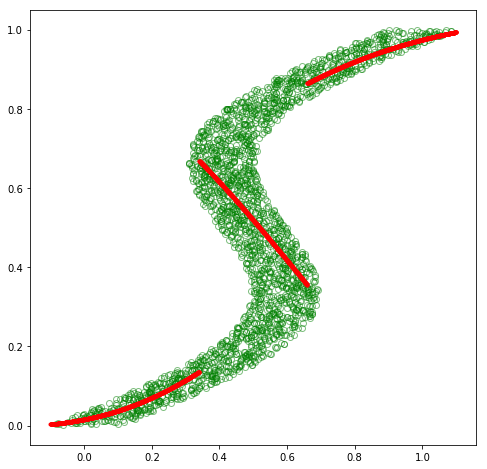

In [17]:
# plot the conditional mode at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, cond_mode.data.numpy(), 'r.')
plt.show()

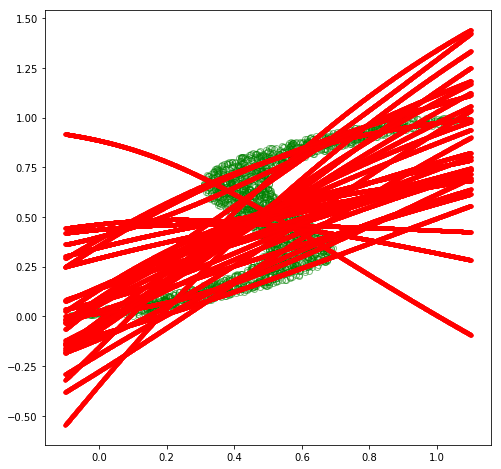

In [18]:
# plot the means at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, mu.data.numpy(), 'r.')
plt.show()

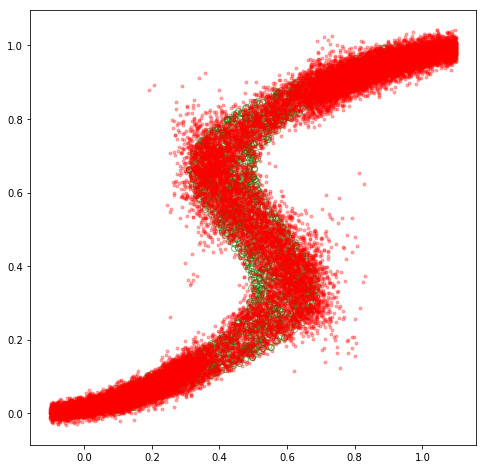

In [19]:
# plot sampled predictions at each point along x
fig = plt.figure(figsize=(8,8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
  plt.plot(x_test, preds.data.numpy()[:, i].reshape(n, 1), 'r.', alpha=0.3)
plt.show()

Fascinating!  Our MDN model appears to have learned to approximate $p(\mathbf{y}|\mathbf{x})$ for this inverse dataset decently well!  We could go back and experiment with different hyperparameter values, such as different values for $K$, which would yield varying levels of fits.  Specifically, the mean plot becomes more intelligible with lower values of $K$, such as $K=3$, while higher values will lead to better fits.

## Final thoughts

Overall, we've explored an interesting "inverse" scenario in which the distribution of our continuous target variable $\mathbf{y}$ exhibits multimodality that is not well approximated by a single Gaussian distribution, and have explored mixture density networks as a general framework for such scenarios.  Hopefully the derivations and implementations here, as well as the great PRML textbook, can serve as useful resources for further exploration of the topic.  

On a parting note, stay curious and remember to have fun!

## Great Resources

1. [Pattern Recognition and Machine Learning (PRML)](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book), pp. 272-277, pp. 430-435
2. [@hardmaru's](https://twitter.com/hardmaru) MDN blogs: [http://blog.otoro.net/2015/06/14/mixture-density-networks](http://blog.otoro.net/2015/06/14/mixture-density-networks), [http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow)
3. [http://edwardlib.org/tutorials/mixture-density-network](http://edwardlib.org/tutorials/mixture-density-network)